# Multivariate HMM with demensionality reduction via principal component analysis

### 1. necessary imports + helpers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from hmmlearn.hmm import GaussianHMM

%matplotlib inline
sns.set_style('darkgrid')

### 2. load data

In [2]:
Z = pd.read_csv("data/macro_panel_standardized.csv", index_col=0, parse_dates=True)
Z

,gdp_yoy,inf_yoy,rate_3m_d1,rate_10y_d1,unemployment_d1
date,,,,,
1954-06-30,-2.263432,-1.030420,-0.410992,-0.224637,0.765015
1954-09-30,-1.557446,-1.291299,0.120248,-0.015858,0.243087
1954-12-31,-0.108478,-1.465614,0.183607,0.267484,-0.895664
1955-03-31,1.270170,-1.500869,0.281082,0.371874,-0.848216
1955-06-30,1.899856,-1.492280,0.363936,0.245115,-0.468632
...,...,...,...,...,...
2024-03-31,-0.037995,-0.115659,-0.089324,-0.642194,0.053295
2024-06-30,0.016863,-0.137507,-0.001596,0.617934,0.243087
2024-09-30,-0.112489,-0.327722,-0.386623,-1.126858,0.243087


### 3. split from ```pd.DataFrame``` to numpy arrays

In [3]:
X = Z.values
dates = Z.index

print(X.shape)

(284, 5)


### 4. PCA fit and scree plot
- stick to two PCs if explain $>70\%$ of the total variance, otherwise possibly bump to 3 PCs

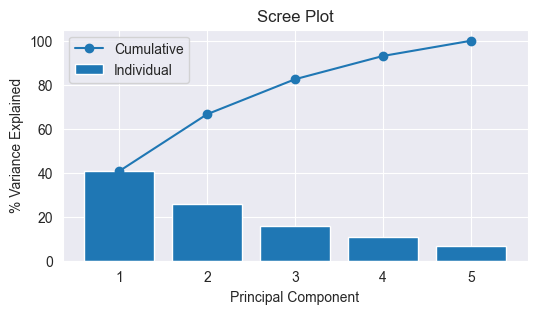

Retaining 3 PCs (cumulative variance = 82.49%)


In [5]:
pca_full = PCA().fit(X)
var_ratios = pca_full.explained_variance_ratio_
cum_var = var_ratios.cumsum()

fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(range(1, 6), var_ratios*100, label='Individual')
ax.plot(range(1, 6), cum_var*100, marker='o', label='Cumulative')
ax.set_xlabel('Principal Component'); ax.set_ylabel('% Variance Explained')
ax.set_xticks(range(1, 6))
ax.set_title('Scree Plot')
ax.legend(); plt.show()

# pick 2 or 3 PCs
n_pc = 2 if cum_var[1] >= 0.70 else 3
print(f"Retaining {n_pc} PCs (cumulative variance = {cum_var[n_pc-1]:.2%})")

In [7]:
pca = PCA(n_components=n_pc)
PCs = pca.fit_transform(X)

pcs_df = pd.DataFrame(
    PCs,
    index=dates,
    columns=[f"PC{i+1}" for i in range(n_pc)],
)

pcs_df

,PC1,PC2,PC3
date,,,
1954-06-30,-1.744438,0.447021,-1.510230
1954-09-30,-0.788440,-0.020446,-1.529916
1954-12-31,0.556876,-1.085337,-0.888674
1955-03-31,1.260790,-1.641419,-0.618020
1955-06-30,1.351410,-1.805799,-0.588332
...,...,...,...
2024-03-31,-0.427684,-0.326664,0.093578
2024-06-30,0.210866,0.253139,-0.374943
2024-09-30,-0.973804,-0.632804,0.072626


### 5. grid search regime count again (just as we did in ```./Direct-GaussianHMM.ipynb```)

In [9]:
results = []
for k in range(1, 5):
    hmm = GaussianHMM(
        n_components=k,
        covariance_type="full",
        n_iter=1000,
        random_state=42,
        verbose=False
    )

    hmm.fit(PCs)
    logL = hmm.score(PCs)
    bic = hmm.bic(PCs)
    aic = hmm.aic(PCs)
    results.append((k, logL, bic, aic, hmm))

    print(f"k={k}  logL={logL:,.1f}  AIC={aic:,.1f}  BIC={bic:,.1f}")

best_k, _, _, _, best_hmm = min(results, key=lambda t: t[2])
print(f"\nSelected k = {best_k}")


k=1  logL=-1,314.2  AIC=2,646.3  BIC=2,679.2
k=2  logL=-1,046.0  AIC=2,134.0  BIC=2,210.6
k=3  logL=-942.0  AIC=1,954.0  BIC=2,081.8
k=4  logL=-939.8  AIC=1,981.6  BIC=2,167.7

Selected k = 3


**interpretation:**
- k=3 had best AIC and BIC, but again k=4 had higher log-likelihood
- going with k=3 again

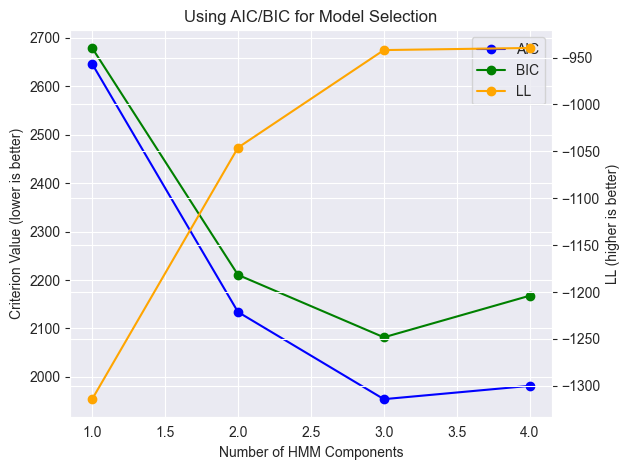

In [13]:
ns = [t[0] for t in results]
lls = [t[1] for t in results]
bics = [t[2] for t in results]
aics = [t[3] for t in results]

fig, ax = plt.subplots()
ln1 = ax.plot(ns, aics, label="AIC", color="blue", marker="o")
ln2 = ax.plot(ns, bics, label="BIC", color="green", marker="o")
ax2 = ax.twinx()
ln3 = ax2.plot(ns, lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

### 6. regime posterior probabilities

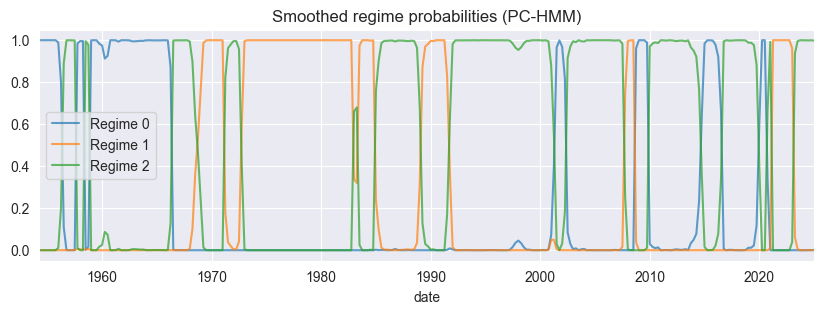

In [15]:
gamma_pc = pd.DataFrame(best_hmm.predict_proba(PCs),
                        index=dates,
                        columns=[f"Regime {s}" for s in range(best_k)])

gamma_pc.plot(figsize=(10, 3), alpha=0.7)
plt.title("Smoothed regime probabilities (PC-HMM)"); plt.show()

**regime prediction with gdp overlayed**

In [16]:
gdp = pd.read_csv("data/macro_panel.csv", index_col=0, parse_dates=True)["gdp_yoy"]
gdp

date
1954-06-30    -9.835032
1954-09-30    -3.085192
1954-12-31    10.768225
1955-03-31    23.949307
1955-06-30    29.969666
                ...    
2024-03-31    11.442103
2024-06-30    11.966597
2024-09-30    10.729869
2024-12-31    10.008472
2025-03-31     8.116101
Name: gdp_yoy, Length: 284, dtype: float64

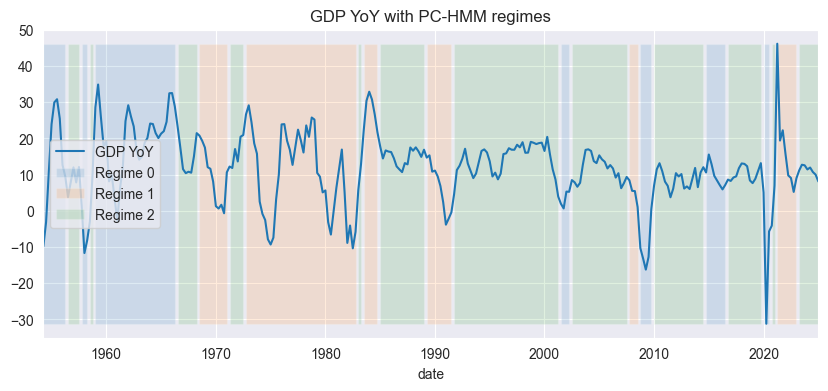

In [18]:
state_pc = best_hmm.predict(PCs)

fig, ax = plt.subplots(figsize=(10, 4))
gdp.plot(ax=ax, label="GDP YoY")
for s in range(best_k):
    mask = (state_pc == s)
    ax.fill_between(
        gdp.index,
        gdp.min(),
        gdp.max(),
        where=mask,
        alpha=0.15,
        label=f"Regime {s}"
    )
ax.legend(); ax.set_title("GDP YoY with PC-HMM regimes")
plt.show()

### 7. Log-Likelihood convergence and expected duration of regimes

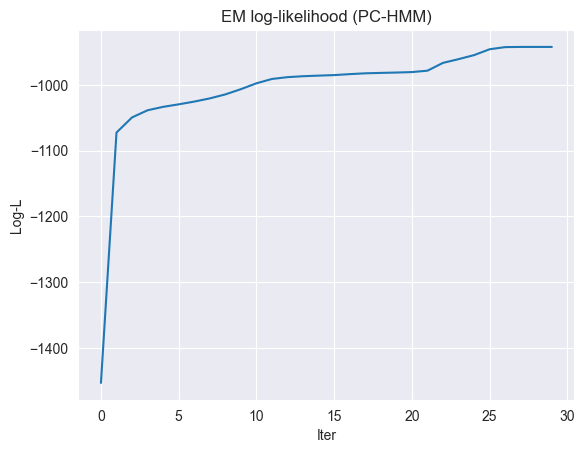

Regime 0     8.4
Regime 1    13.7
Regime 2    12.8
Name: Expected duration (quarters), dtype: float64


In [21]:
plt.plot(best_hmm.monitor_.history)
plt.title("EM log-likelihood (PC-HMM)"); plt.xlabel("Iter"); plt.ylabel("Log-L")
plt.show()

dur_pc = 1 / (1 - np.diag(best_hmm.transmat_))
print(pd.Series(dur_pc, index=[f"Regime {i}" for i in range(best_k)])
      .round(1).rename("Expected duration (quarters)"))


### 8. map regime means back to original 5-var space

In [22]:
recon = (best_hmm.means_ @ pca.components_) * Z.std().values + Z.mean().values
pd.DataFrame(recon, columns=Z.columns).round(2)


,gdp_yoy,inf_yoy,rate_3m_d1,rate_10y_d1,unemployment_d1
0,-0.04,-0.88,-0.03,-0.15,0.18
1,-0.18,1.21,-0.02,0.17,0.00
2,0.12,-0.30,0.03,-0.03,-0.08


**interpretation:**
- interestingly when using PCA, there is one clear regime mapping to growth cycles and then two relatively unclear regimes:
    1. with *moderately* low negative GDP growth and a large increase in unemployement
    2. with significantly negative GDP growth and 0 difference in unemployment

### 8a. approximate covariance matrix in 5-var space

In [23]:
P = pca.components_

cov_orig = []
for r in range(best_k):
    Sigma_pc = best_hmm.covars_[r]
    Sigma_hat = P.T @ Sigma_pc @ P
    cov_orig.append(Sigma_hat)

# Display regime 3 (change r to change)
r = 2
pd.DataFrame(cov_orig[r], index=Z.columns, columns=Z.columns)\
  .round(3).style.background_gradient(cmap="viridis")


,gdp_yoy,inf_yoy,rate_3m_d1,rate_10y_d1,unemployment_d1
gdp_yoy,0.072000,-0.002000,0.040000,0.029000,-0.075000
inf_yoy,-0.002000,0.082000,0.037000,0.050000,-0.009000
rate_3m_d1,0.040000,0.037000,0.379000,0.389000,-0.034000
rate_10y_d1,0.029000,0.050000,0.389000,0.403000,-0.024000
unemployment_d1,-0.075000,-0.009000,-0.034000,-0.024000,0.079000


### 8b. transition probabilities

In [24]:
print("Transition matrix (row = from, col = to):")
pd.DataFrame(
    best_hmm.transmat_,
    index=[f"Regime {i}" for i in range(best_k)],
    columns=[f"Regime {i}" for i in range(best_k)]
).round(3)

Transition matrix (row = from, col = to):


,Regime 0,Regime 1,Regime 2
Regime 0,0.882,0.000,0.118
Regime 1,0.014,0.927,0.059
Regime 2,0.037,0.041,0.922


**again the diagonals are close to 1 indicating regime persistence**